In [1]:
library(Seurat)
library(Matrix)
library(useful)
library(harmony)
library(dplyr)
library(sva)
library(RColorBrewer)
library(Scillus)
library(ggrepel)
library(stringr)
library(ggpubr)
library(fgsea)
library(reshape2)
library(viridis)

set.seed(1234)

Attaching SeuratObject

Attaching sp

Loading required package: ggplot2

Loading required package: Rcpp


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: mgcv

Loading required package: nlme


Attaching package: 'nlme'


The following object is masked from 'package:dplyr':

    collapse


This is mgcv 1.8-36. For overview type 'help("mgcv-package")'.

Loading required package: genefilter

Loading required package: BiocParallel

Loading required package: viridisLite



### 1. Use complete granular annotations to re-define broad cell types 

In [2]:
seur_i = readRDS(file = "Manuscript_Objects/Immune_SeuratObject.RDS")
table(Idents(seur_i))


    LowQual         pDC   gd_T_cell       T_reg  Neutrophil          NK 
       4741          81         270         228        1086         719 
        NKT    Monocyte  Macrophage        MDSC         cDC  CD8_T_cell 
       1466        2214        5601        2229        1022        4000 
   T_Helper Plasma_cell 
        734        1815 

In [26]:
table(seur_i$Annot_Imm_1_Cycling_ISG_Resolved_Granular)


           CD4_EffectorMem_Id2                 CD4_Naive_Lef1 
                           469                            265 
             CD8_Cycling_Mki67          CD8_EffectorMem_Klrc2 
                           345                            115 
           CD8_Effector_Cx3cr1             CD8_ISG_High_Isg15 
                           657                            235 
               CD8_Memory_Il7r               CD8_NKlike_Cd160 
                           101                            190 
                CD8_Naive_Sell                        CD8_Tox 
                           314                           1492 
                 CD8_Trm_Itgae                        DC_Ccr7 
                           551                             75 
                     DC_Cd209a               DC_Cycling_Mki67 
                           693                            131 
                     DC_Retnla                        DC_Xcr1 
                            77                        

In [27]:
plasma_cell = c("Plasma_cell_Igkc")
thelper = c("CD4_EffectorMem_Id2","CD4_Naive_Lef1")
cd8 = c("CD8_Cycling_Mki67","CD8_EffectorMem_Klrc2","CD8_Effector_Cx3cr1","CD8_ISG_High_Isg15","CD8_NKlike_Cd160","CD8_Naive_Sell","CD8_Memory_Il7r","CD8_Tox","CD8_Trm_Itgae")
cdc = c("DC_Ccr7","DC_Cd209a","DC_Cycling_Mki67","DC_Retnla","DC_Xcr1")
mdsc = c("MDSC_Arg1","MDSC_Cycling_Mki67","MDSC_ISG_High_Isg15")
mac = c("Macrophage_Cycling_Mki67","Macrophage_Fabp5","Macrophage_H2Eb1","Macrophage_ISG_High_Isg15","Macrophage_Mrc1","Macrophage_Olfml3","Macrophage_Vcam1")
mono = c("Monocyte_Ace","Monocyte_ISG_High_Isg15","Monocyte_Plac8")
nkt = c("NKT_Cd8pos_Cd8b1","NKT_ISG_High_Ifit3","NKT_Ly6a")
nk = c("NK_Cycling_Mki67","NK_Gzma","NK_Klrb1b")
neut = c("Neutrophil_S100a9","Neutrophil_Ccl3")
treg = c("T_reg_Foxp3")
gd = c("gd_T_cell_Trdc")
pdc = c("pDC_Siglech")
omits = c("LowLibSize_Contaminant","LowLibSize_THlike_Unidentified","Lymphoid_Contaminant","Macrophage_AmbientHigh_Ftl1","MitoHigh_Lymphoid","MitoHigh_Myeloid","MitoHigh_NKT","Myeloid_Contaminant","PT_Contaminant","Stromal_Contaminant","Unidentified")

In [28]:
meta = seur_i@meta.data

seur_i = SetIdent(seur_i, cells = row.names(subset(meta, Annot_Imm_1_Cycling_ISG_Resolved_Granular %in% plasma_cell)),value = "Plasma_cell")
seur_i = SetIdent(seur_i, cells = row.names(subset(meta, Annot_Imm_1_Cycling_ISG_Resolved_Granular %in% thelper)),value = "T_Helper")
seur_i = SetIdent(seur_i, cells = row.names(subset(meta, Annot_Imm_1_Cycling_ISG_Resolved_Granular %in% cd8)),value = "CD8_T_cell")
seur_i = SetIdent(seur_i, cells = row.names(subset(meta, Annot_Imm_1_Cycling_ISG_Resolved_Granular %in% cdc)),value = "cDC")
seur_i = SetIdent(seur_i, cells = row.names(subset(meta, Annot_Imm_1_Cycling_ISG_Resolved_Granular %in% mdsc)),value = "MDSC")
seur_i = SetIdent(seur_i, cells = row.names(subset(meta, Annot_Imm_1_Cycling_ISG_Resolved_Granular %in% mac)),value = "Macrophage")
seur_i = SetIdent(seur_i, cells = row.names(subset(meta, Annot_Imm_1_Cycling_ISG_Resolved_Granular %in% mono)),value = "Monocyte")
seur_i = SetIdent(seur_i, cells = row.names(subset(meta, Annot_Imm_1_Cycling_ISG_Resolved_Granular %in% nkt)),value = "NKT")
seur_i = SetIdent(seur_i, cells = row.names(subset(meta, Annot_Imm_1_Cycling_ISG_Resolved_Granular %in% nk)),value = "NK")
seur_i = SetIdent(seur_i, cells = row.names(subset(meta, Annot_Imm_1_Cycling_ISG_Resolved_Granular %in% neut)),value = "Neutrophil")
seur_i = SetIdent(seur_i, cells = row.names(subset(meta, Annot_Imm_1_Cycling_ISG_Resolved_Granular %in% treg)),value = "T_reg")
seur_i = SetIdent(seur_i, cells = row.names(subset(meta, Annot_Imm_1_Cycling_ISG_Resolved_Granular %in% gd)),value = "gd_T_cell")
seur_i = SetIdent(seur_i, cells = row.names(subset(meta, Annot_Imm_1_Cycling_ISG_Resolved_Granular %in% pdc)),value = "pDC")
seur_i = SetIdent(seur_i, cells = row.names(subset(meta, Annot_Imm_1_Cycling_ISG_Resolved_Granular %in% omits)),value = "LowQual")

seur_i$Immune_Broad_CellType = Idents(seur_i)

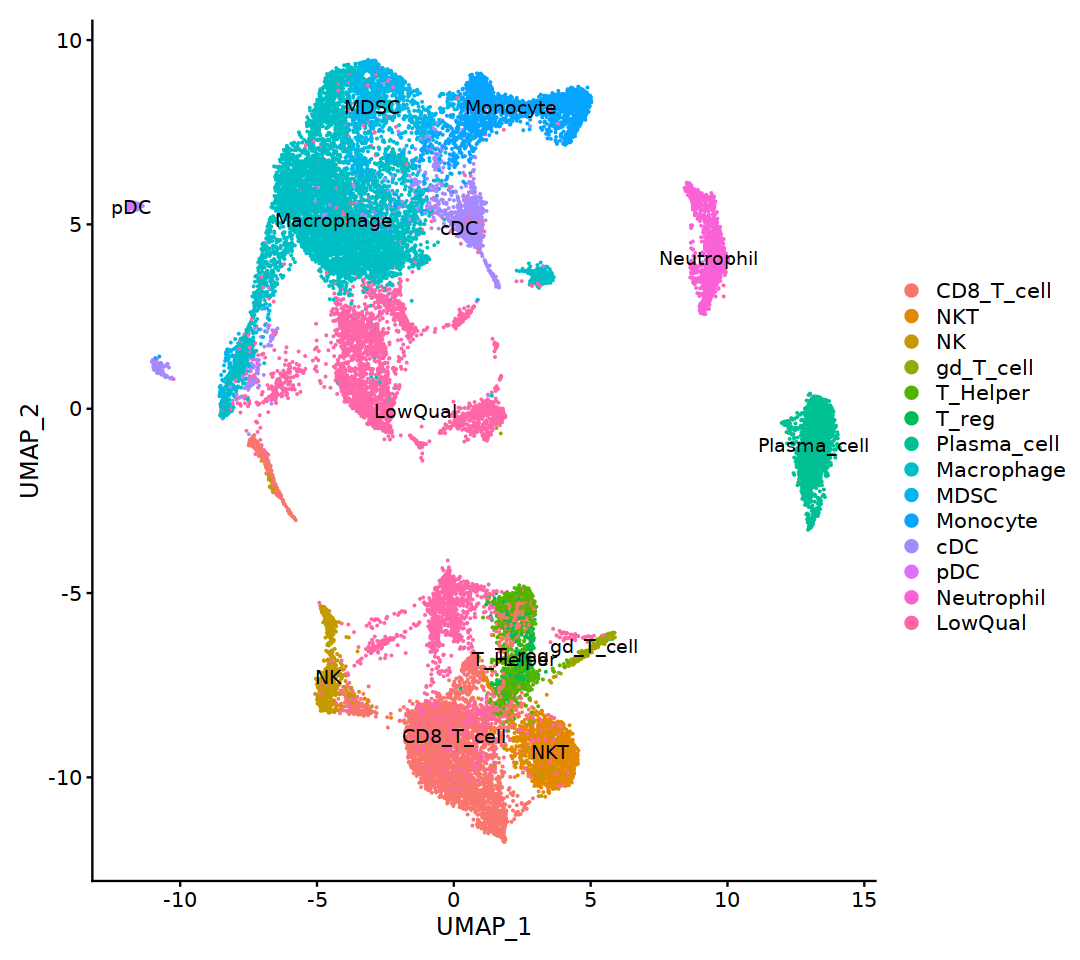

In [29]:
Idents(seur_i) = factor(Idents(seur_i), levels = c("CD8_T_cell","NKT","NK","gd_T_cell","T_Helper","T_reg","Plasma_cell","Macrophage","MDSC","Monocyte","cDC","pDC","Neutrophil","LowQual"))

options(repr.plot.width=9, repr.plot.height=8)
DimPlot(seur_i, label = T)

In [30]:
mycols = c(colorRampPalette(brewer.pal(8, "Set3"))(13),"gray95")
names(mycols) = as.character(levels(Idents(seur_i)))
mycols

CD8_T_cell         NKT          NK   gd_T_cell    T_Helper       T_reg 
  "#8DD3C7"   "#CFECBB"   "#F4F3B9"   "#CECBD0"   "#D2A6B7"   "#F5847A" 
Plasma_cell  Macrophage        MDSC    Monocyte         cDC         pDC 
  "#BD98A2"   "#8AB1C9"   "#D3B387"   "#EABE63"   "#BFD767"   "#D1D69C" 
 Neutrophil     LowQual 
  "#FCCDE5"    "gray95"

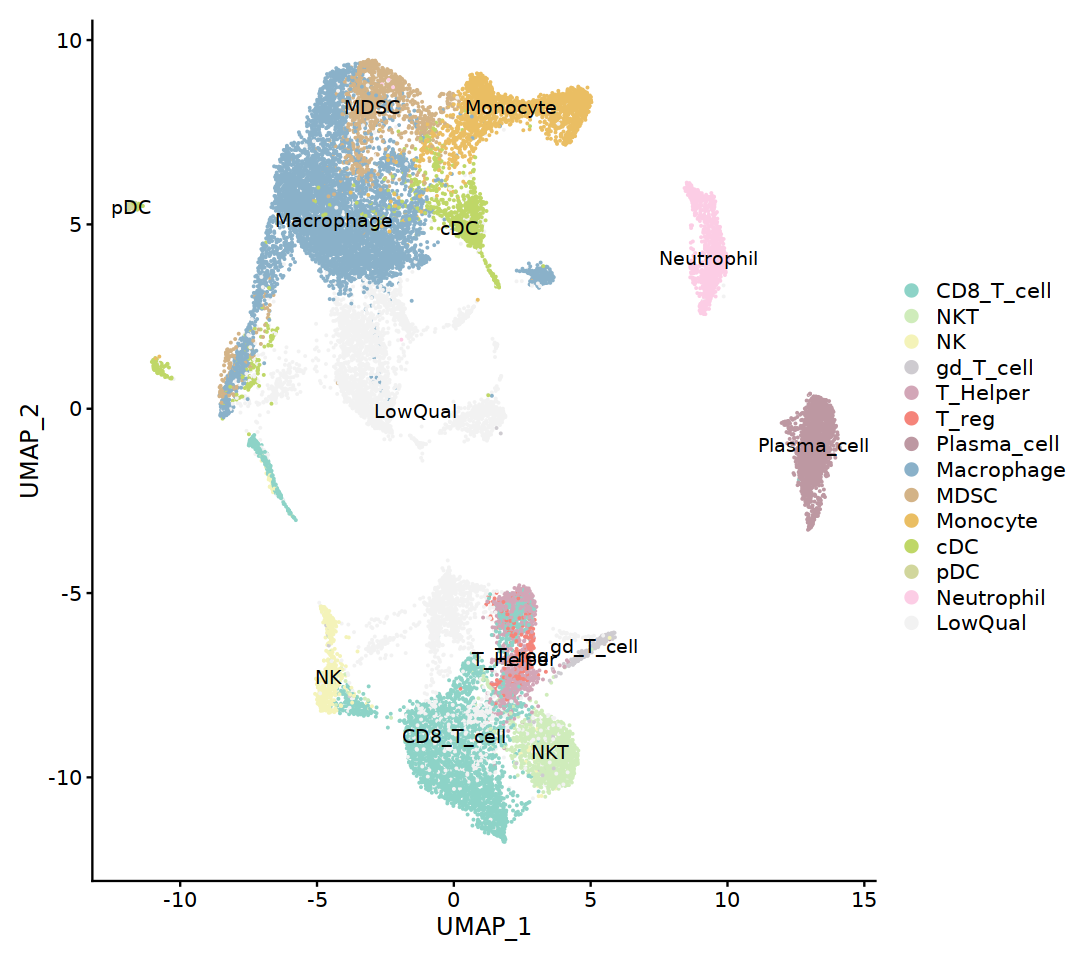

In [31]:
options(repr.plot.width=9, repr.plot.height=8)
DimPlot(seur_i, label = T, cols = mycols)

ggsave("Manuscript_Figures/Immune_UMAP_CellType.pdf", width = 9, height = 8)

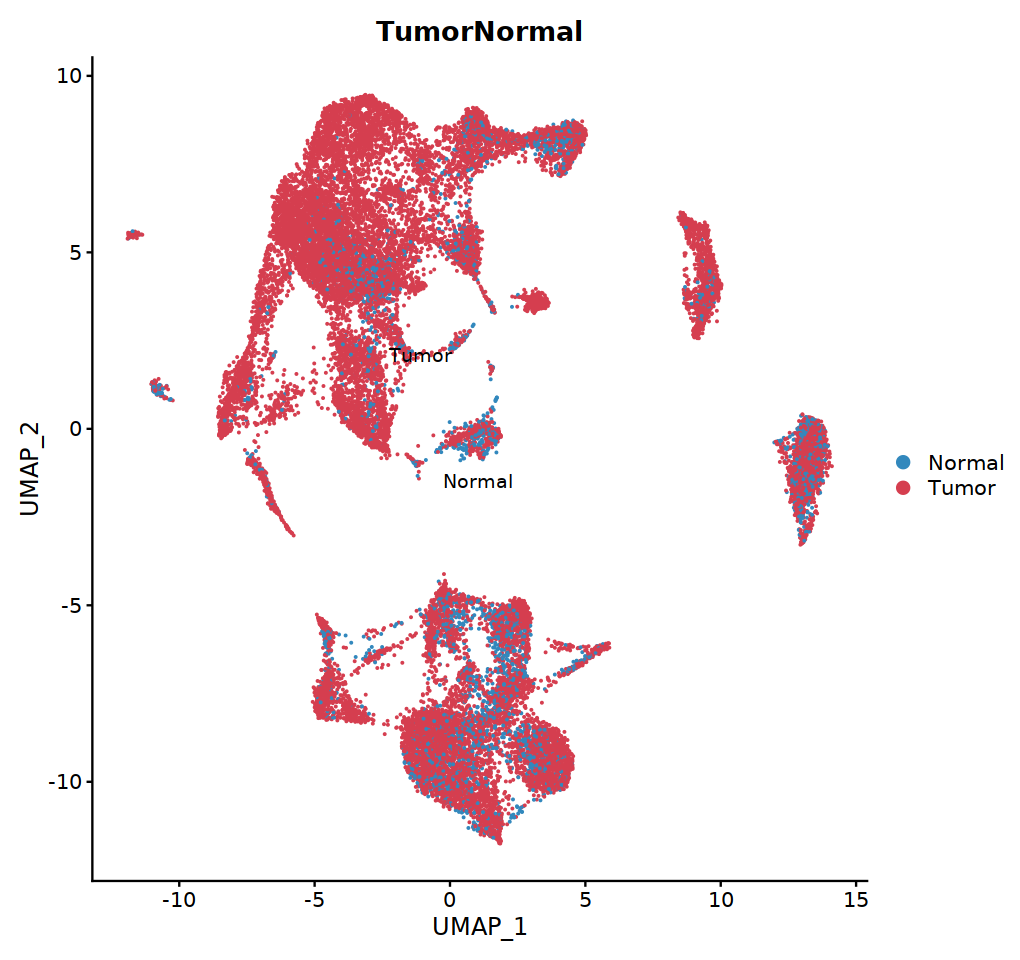

In [32]:
options(repr.plot.width=8.5, repr.plot.height=8)
DimPlot(seur_i, label = T, group.by = "TumorNormal",cols = c("#3288bd","#d53e4f"), shuffle = T)

ggsave("Manuscript_Figures/Immune_UMAP_TumorNormal.pdf", width = 8.5, height = 8)

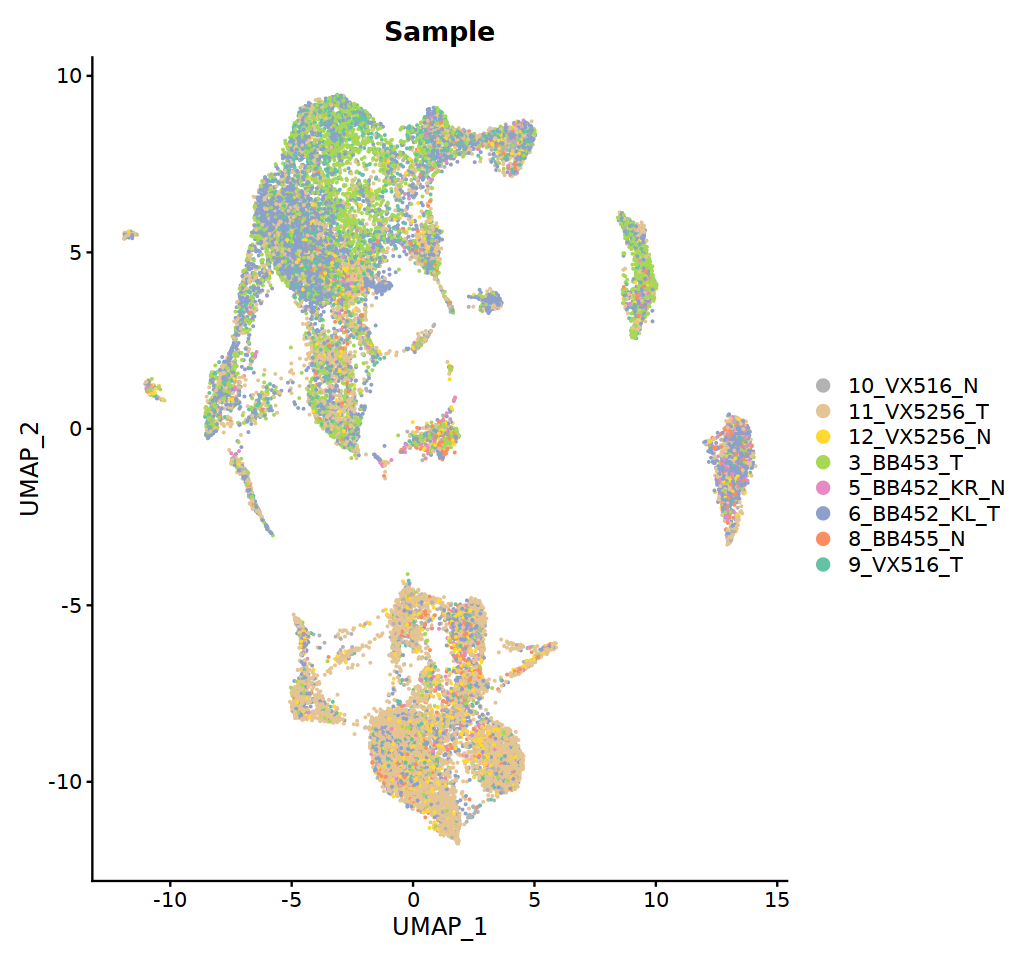

In [33]:
options(repr.plot.width=8.5, repr.plot.height=8)
DimPlot(seur_i, group.by = "Sample", cols = rev(brewer.pal(8, "Set2")),shuffle = T) 

ggsave("Manuscript_Figures/Immune_UMAP_Sample.pdf", width = 8.5, height = 8)

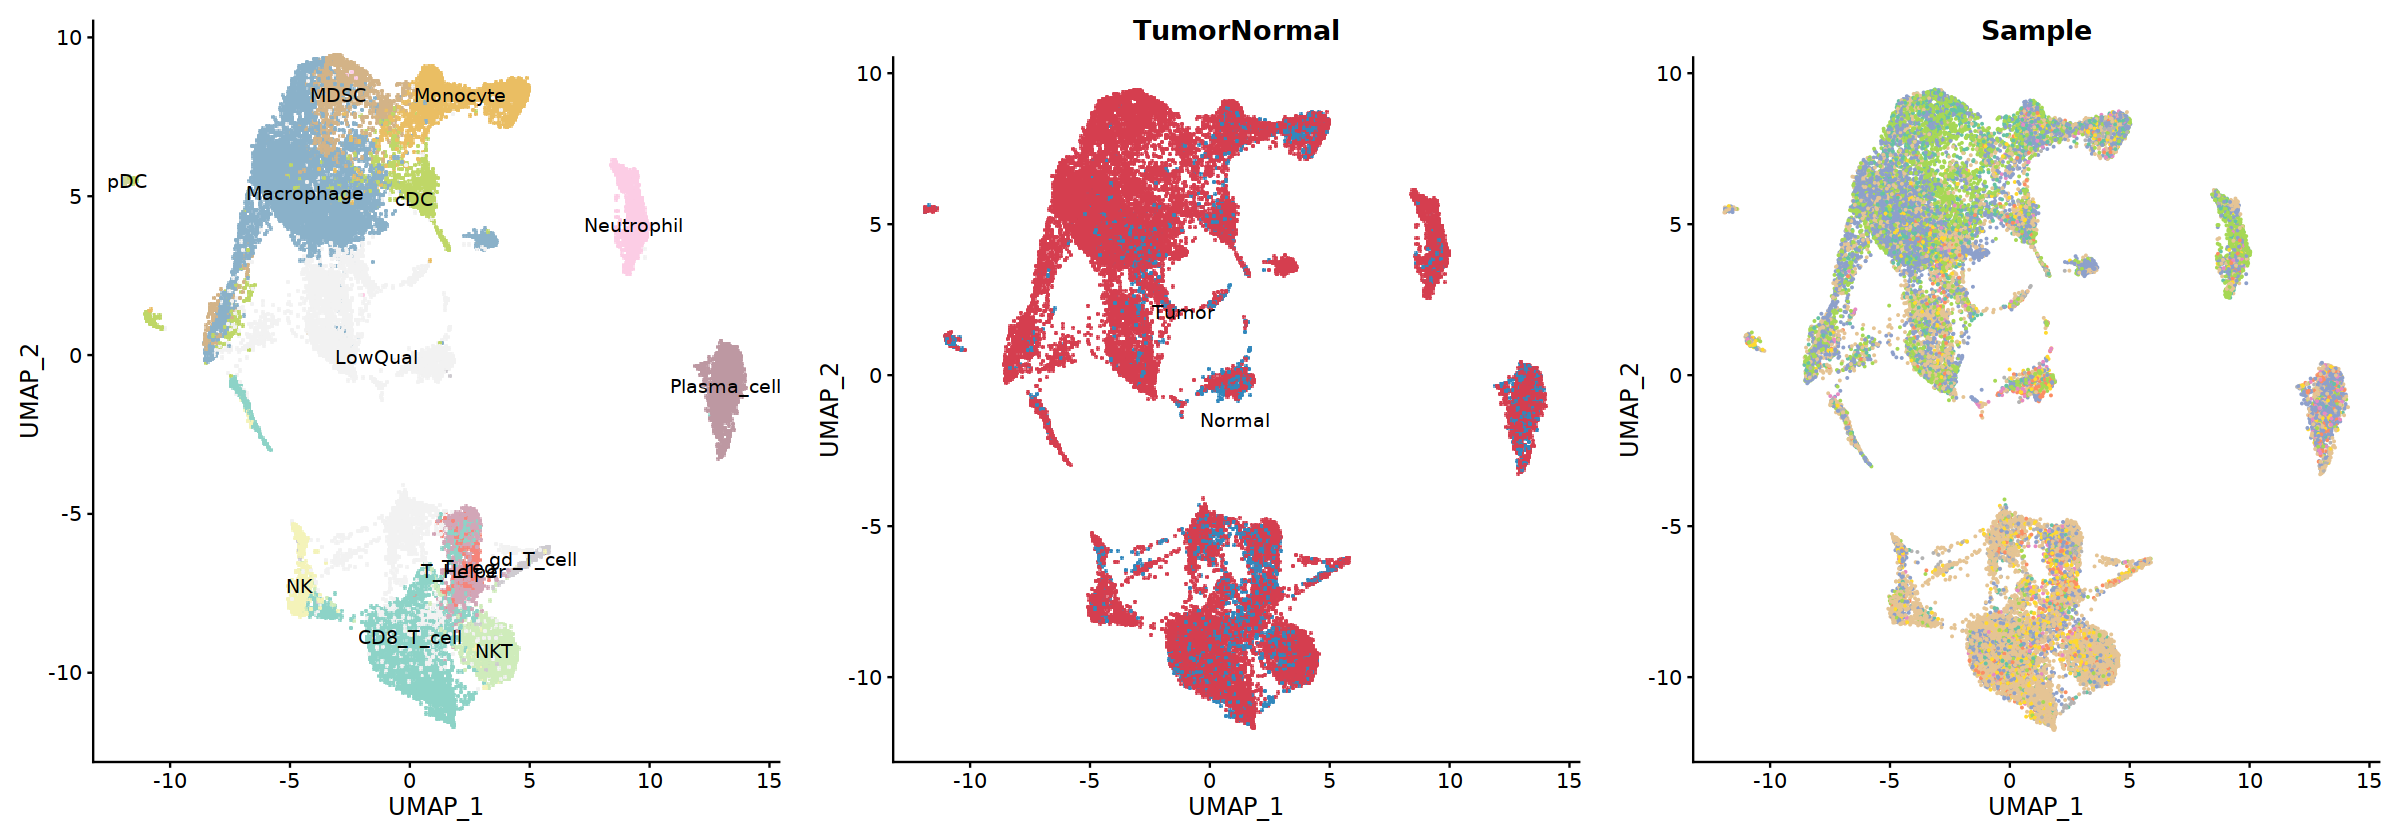

In [34]:
one = DimPlot(seur_i, label = T, cols = mycols,raster = T) + NoLegend()
two = DimPlot(seur_i, label = T, raster = T,group.by = "TumorNormal",cols = c("#3288bd","#d53e4f"), shuffle = T) + NoLegend()
three = DimPlot(seur_i, group.by = "Sample", cols = rev(brewer.pal(8, "Set2")),shuffle = T) + NoLegend()

library(ggpubr)
options(repr.plot.width=20, repr.plot.height=7)
ggarrange(one, two,three, nrow = 1)

ggsave("Manuscript_Figures/Immune_UMAPs_Combined_CellType_TumorNormal_Sample.pdf", width = 15, height = 7.5)

In [35]:
saveRDS(seur_i, file = "Manuscript_Objects/Immune_SeuratObject.RDS")

### Plot again removing low quality cells

Centering and scaling data matrix

PC_ 1 
Positive:  Ptprcap, Ltb, Gimap4, Gimap1, Ms4a4b, Gimap3, Gimap6, H2-Q7, Trbc2, Cd3g 
	   Cd3d, Nkg7, Cd3e, Lck, Sept1, Trac, Skap1, Thy1, S100a10, Ablim1 
	   Cd2, Ctsw, Tmsb10, Ccl5, Ccnd2, Gimap7, Lat, Bcl2, Gimap9, Cxcr6 
Negative:  Lyz2, Apoe, Ctss, Ftl1, Ctsz, Ctsb, Lgmn, Grn, Psap, Csf1r 
	   C1qb, Cst3, Cd68, C1qc, C1qa, Hexb, Lamp1, Ctsh, Tyrobp, Mpeg1 
	   Fcer1g, Aif1, Trem2, Mafb, Fth1, Hexa, Trf, Itgb5, Lamp2, Fcgr3 
PC_ 2 
Positive:  Hp, Gsr, Lst1, Msrb1, Il1b, Cd300a, Zfp36, Csf3r, Gda, Fgr 
	   S100a8, Ifitm6, S100a9, Neat1, Cxcr2, Slpi, Cebpb, Ifitm2, Gpr141, Nr4a1 
	   Cd300ld, Ace, Ccl6, Ifitm3, Napsa, Tnfaip2, Dusp1, Gcnt2, Plac8, Mcemp1 
Negative:  Top2a, Pclaf, Mki67, Birc5, Nusap1, Stmn1, Spc24, Kif11, Ccna2, Cdca3 
	   Cdk1, Prc1, Cenpf, Tpx2, Knl1, Cdca8, Esco2, Hmmr, Rrm2, Hist1h1b 
	   Kif15, Ube2c, Cenpe, Pbk, Hist1h3c, Ckap2l, Cks1b, Tk1, Spc25, Aurkb 
PC_ 3 
Positive:  Pmepa1, Ms4a7, Olfml3, C1qc, C1qa, Cd81, AW1120

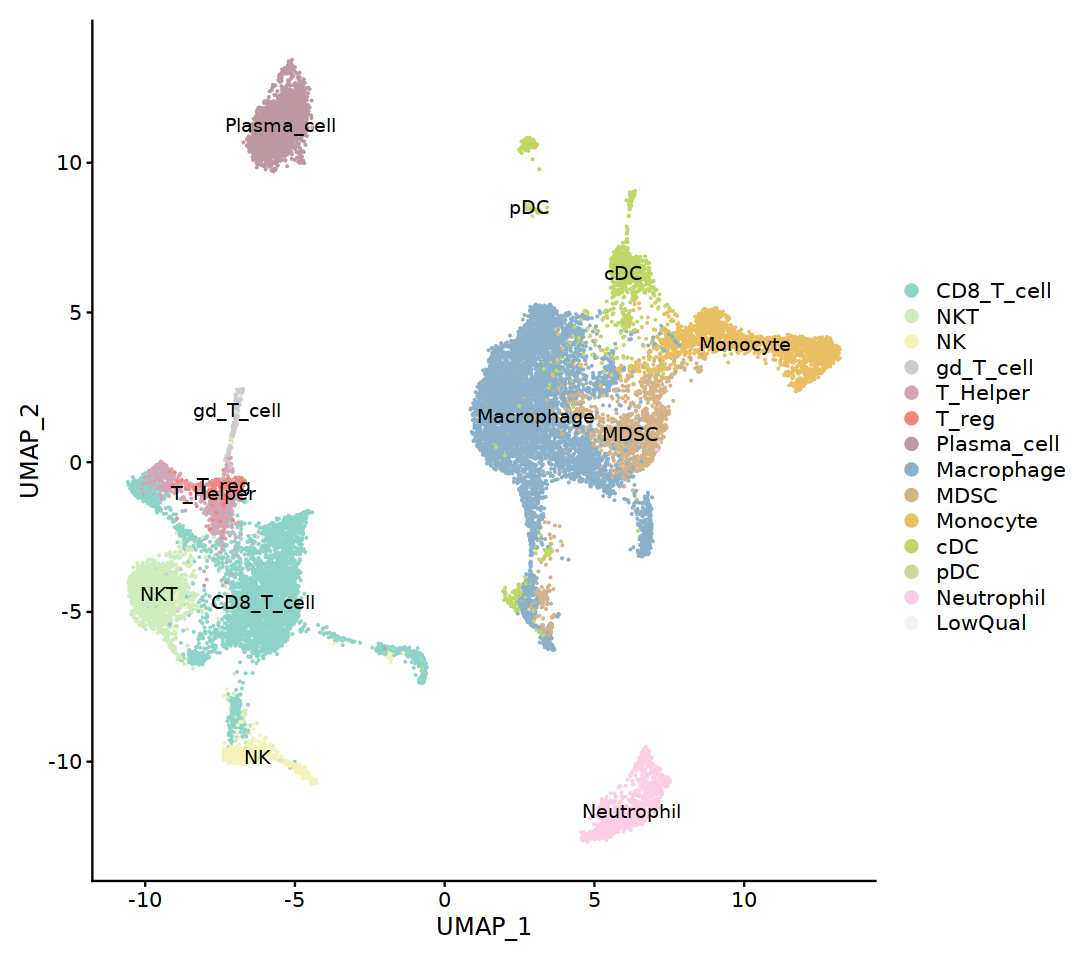

In [36]:
seur_i = subset(seur_i, idents = "LowQual", invert = T)
seur_i <- NormalizeData(seur_i)
seur_i <- FindVariableFeatures(seur_i, selection.method = "vst",nfeatures = 3000)
seur_i <- ScaleData(seur_i, features = row.names(seur_i))
seur_i <- RunPCA(seur_i, npcs = 30,verbose = T)
seur_i <- RunHarmony(seur_i, group.by.vars = "Sample")
seur_i <- RunUMAP(seur_i, reduction = "harmony", dims = 1:30)
#seur_i <- FindNeighbors(seur_i, reduction = "harmony", dims = 1:30)
#seur_i <- FindClusters(seur_i, resolution = 0.5)

options(repr.plot.width=9, repr.plot.height=8)
DimPlot(seur_i, label = T, cols = mycols)

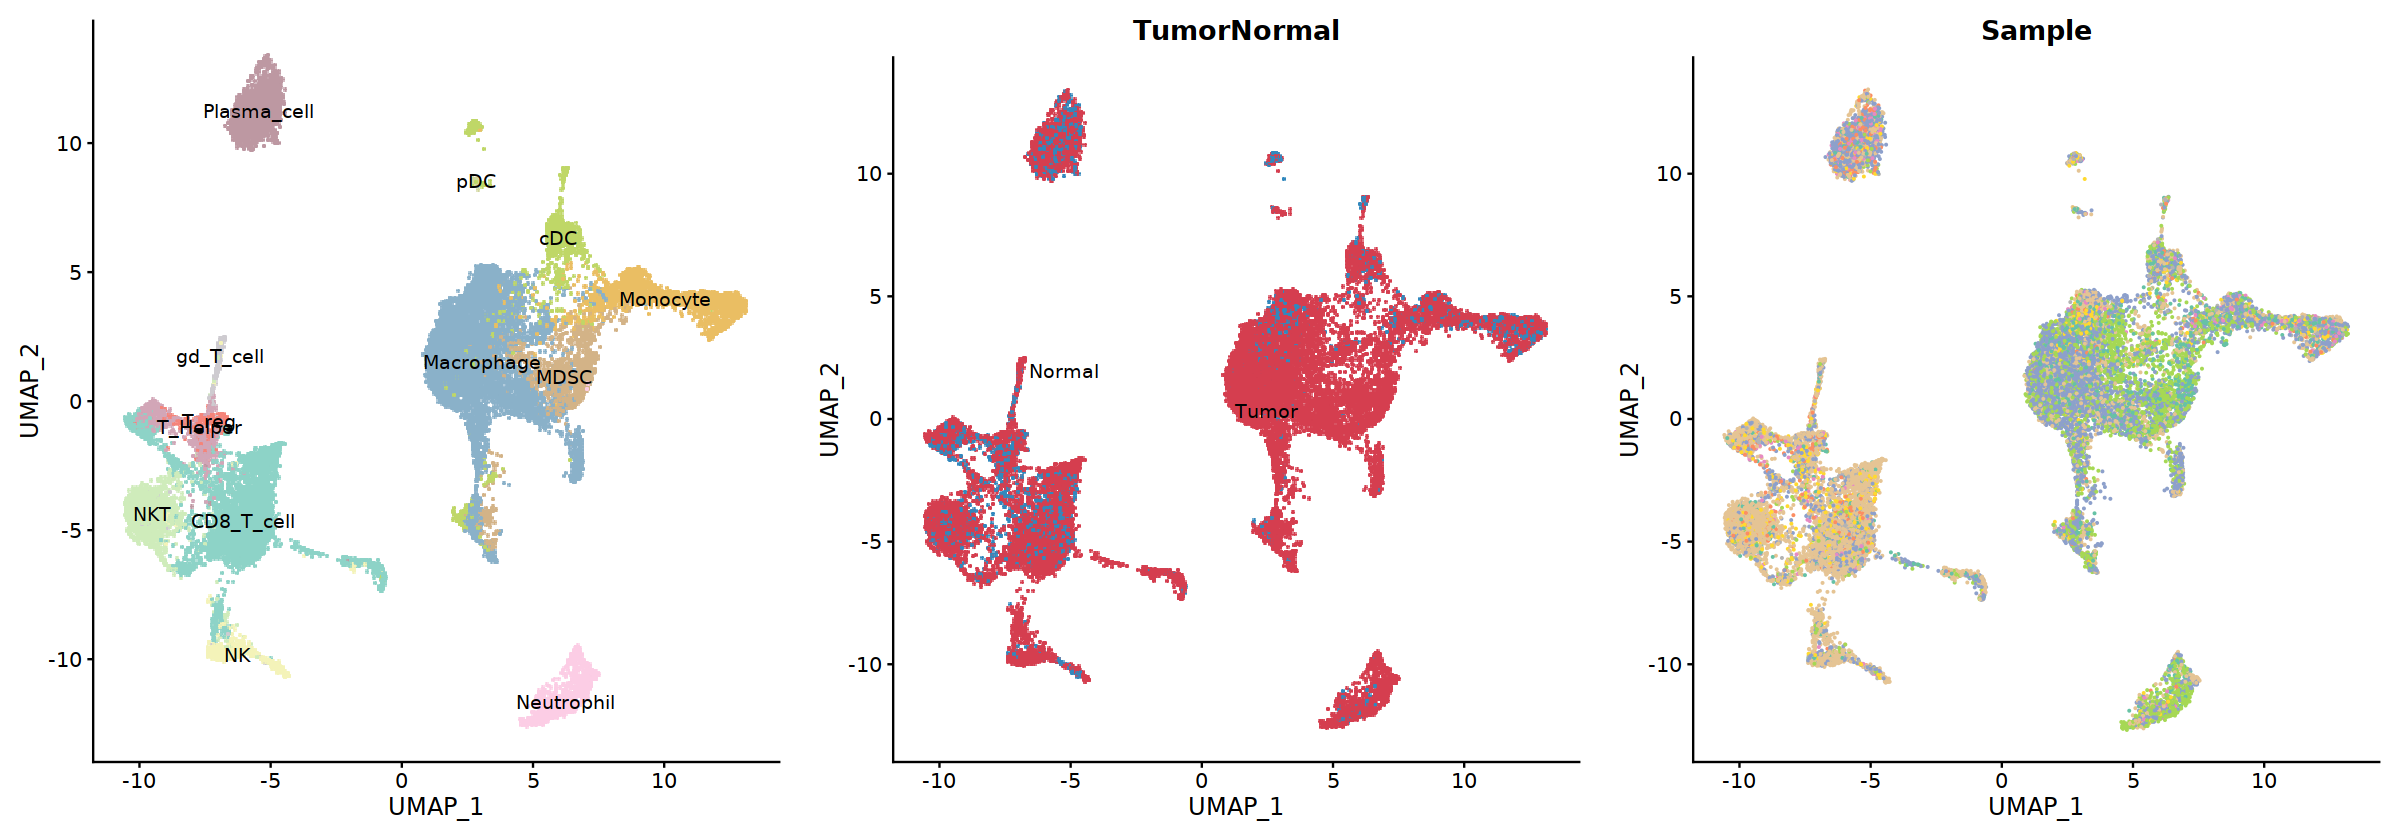

In [37]:
one = DimPlot(seur_i, label = T, cols = mycols,raster = T) + NoLegend()
two = DimPlot(seur_i, label = T, raster = T,group.by = "TumorNormal",cols = c("#3288bd","#d53e4f"), shuffle = T) + NoLegend()
three = DimPlot(seur_i, group.by = "Sample", cols = rev(brewer.pal(8, "Set2")),shuffle = T) + NoLegend()

library(ggpubr)
options(repr.plot.width=20, repr.plot.height=7)
ggarrange(one, two,three, nrow = 1)

ggsave("Manuscript_Figures/Immune_LowQualRemoved_UMAPs_Combined_CellType_TumorNormal_Sample.pdf", width = 15, height = 7.5)

,Var1,Var2,Freq
,<fct>,<fct>,<dbl>
1,10_VX516_N,CD8_T_cell,0.03075
2,11_VX5256_T,CD8_T_cell,0.62575
3,12_VX5256_N,CD8_T_cell,0.07500
4,3_BB453_T,CD8_T_cell,0.03600
5,5_BB452_KR_N,CD8_T_cell,0.01600


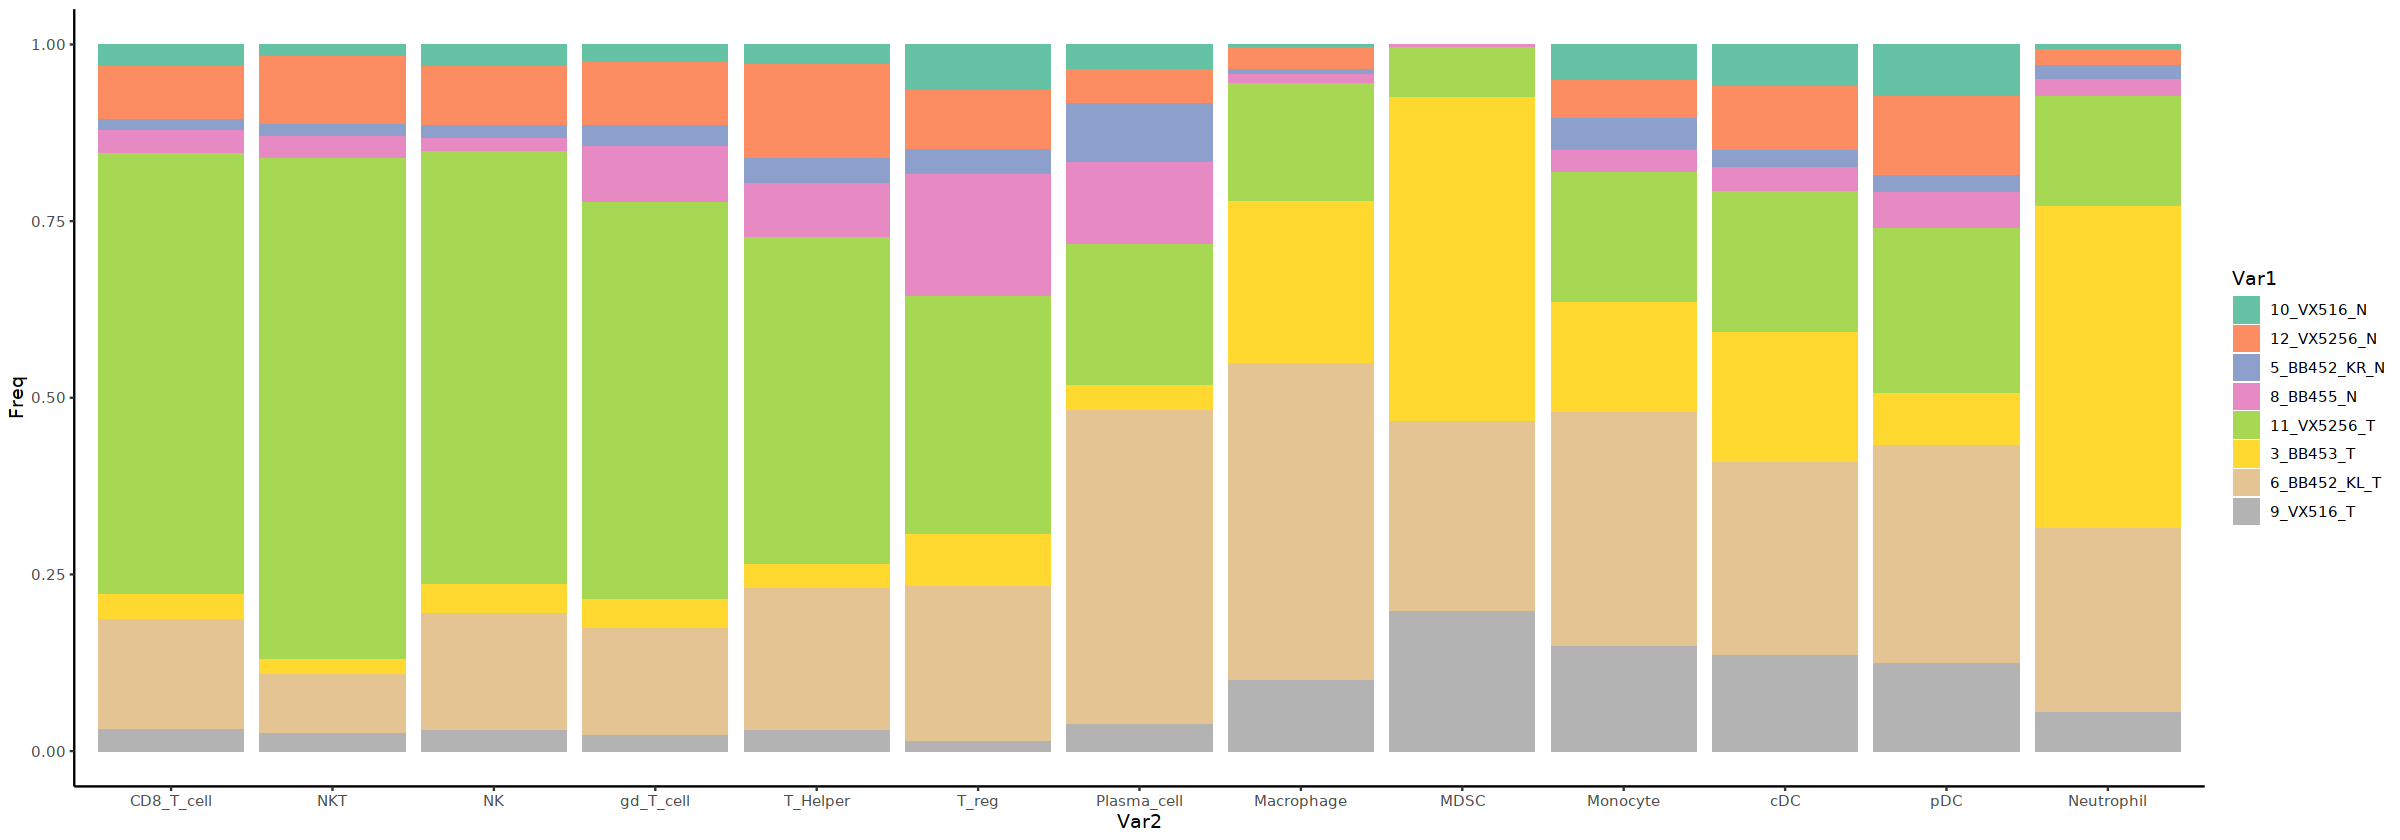

In [38]:
props <- prop.table(table(seur_i$Sample,Idents(seur_i)), margin = 2)
props <- data.frame(props)
corner(props)
props$Var1 <- factor(props$Var1, levels = c("10_VX516_N","12_VX5256_N","5_BB452_KR_N","8_BB455_N","11_VX5256_T","3_BB453_T","6_BB452_KL_T","9_VX516_T"))
ggplot() + geom_bar(aes(y = Freq, x = Var2, fill = Var1), data = props, stat="identity") +theme(axis.text.x = element_text(size=14),
          axis.text.y = element_text(size=14)) + scale_fill_manual(values = brewer.pal(8, "Set2")) + theme_classic()


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



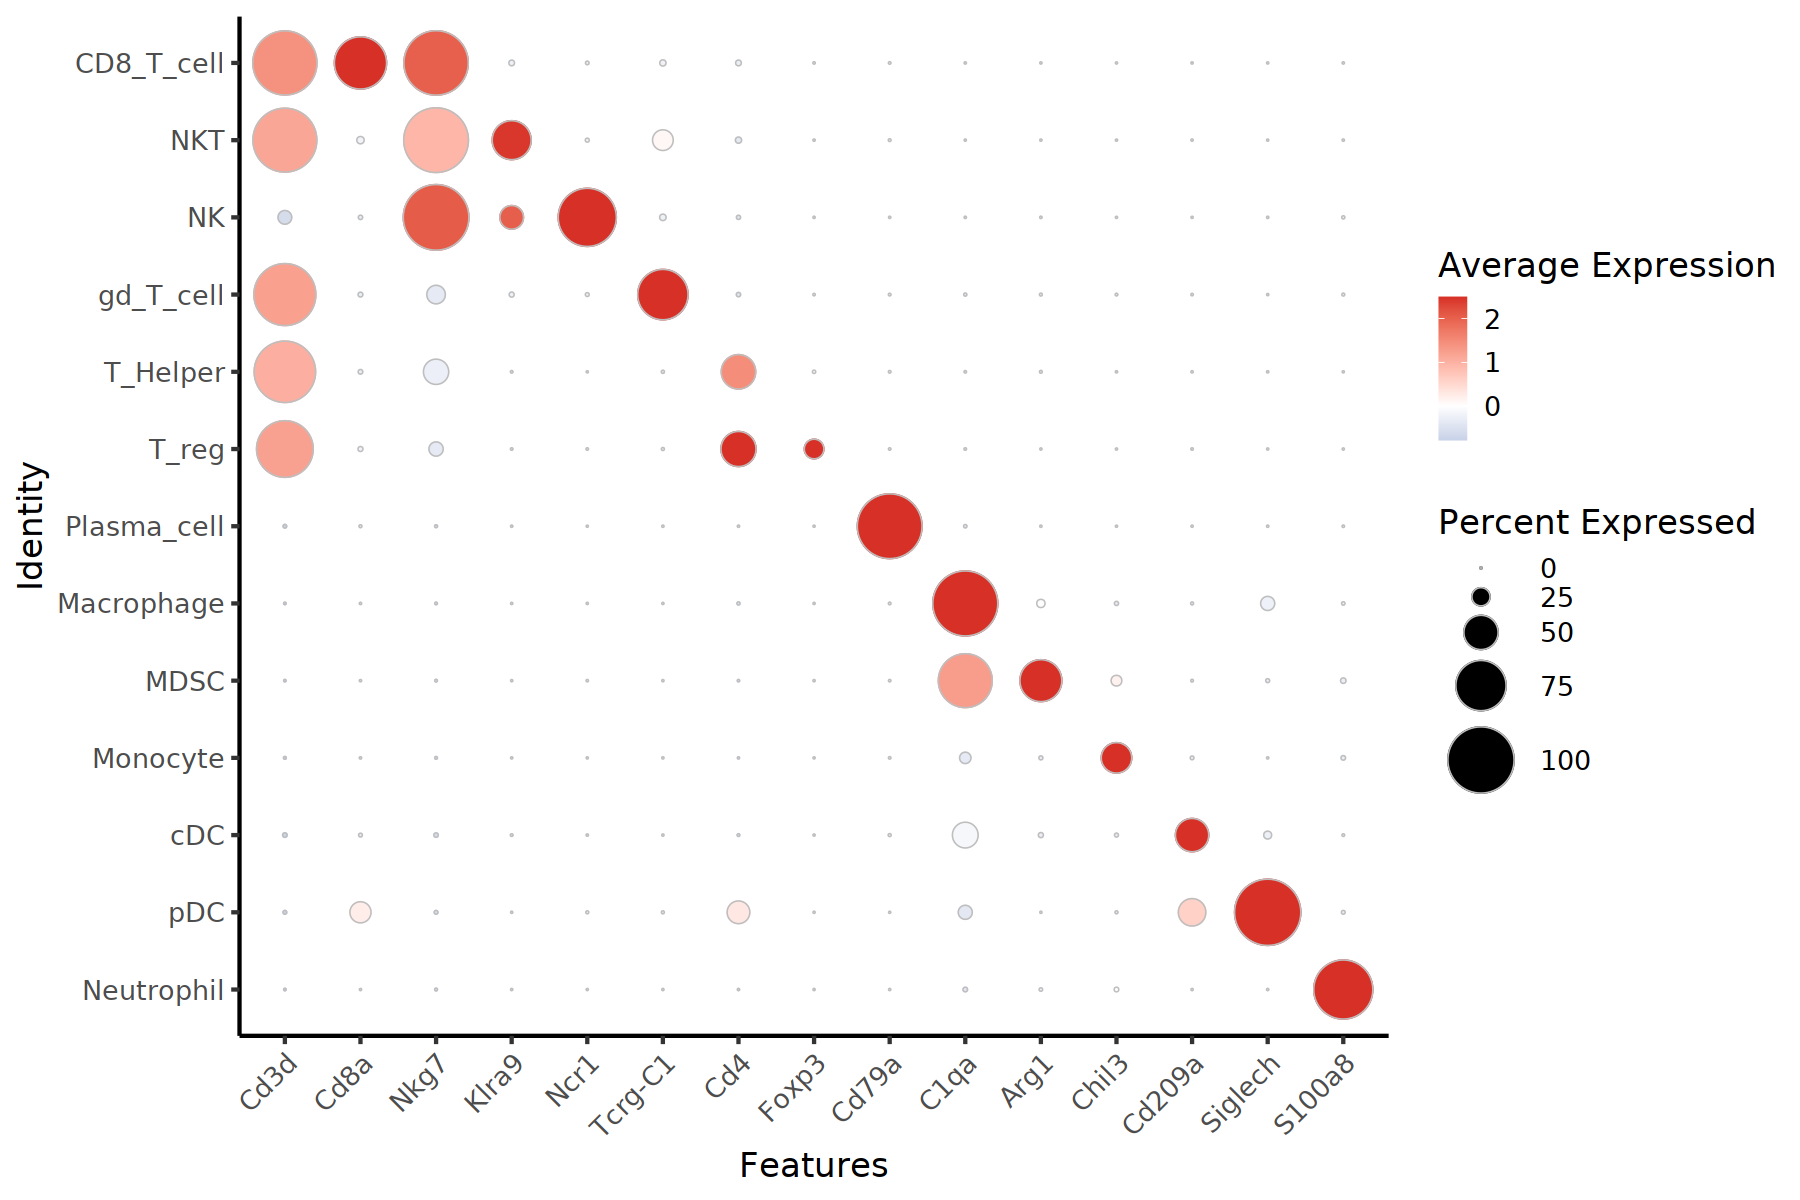

In [39]:
options(repr.plot.width=15, repr.plot.height=10)

Idents(seur_i) = factor(Idents(seur_i), levels = rev(levels(Idents(seur_i))))

DotPlot(seur_i, features = c("Cd3d","Cd8a","Nkg7","Klra9","Ncr1","Tcrg-C1","Cd4","Foxp3","Cd79a","C1qa","Arg1","Chil3","Cd209a","Siglech","S100a8"),assay = "RNA",dot.scale = 18, cols = c("white","red")) + theme_classic(base_size = 20) +
geom_point(aes(size = pct.exp),shape = 21, color = "grey",stroke = 0.5) + 
scale_colour_gradient2(low = "#4575b4", mid = "white", high = "#d73027") +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

Idents(seur_i) = factor(Idents(seur_i), levels = rev(levels(Idents(seur_i))))

ggsave("Manuscript_Figures/Immune_Dotplot_Markers.pdf", width = 15, height = 10)